In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from influenza_USA.NC_forecasts.utils import get_NC_influenza_data

## Forecast figure 

In [41]:
# settings
season = '2023-2024'
model = 'oneStrain'
start_visualisation = datetime(int(season[0:4]), 10, 15)
end_visualisation = datetime(int(season[0:4])+1, 2, 7)

# load forecasts
files = [f for f in os.listdir(f'{season}/{model}') 
             if os.path.isfile(os.path.join(f'{season}/{model}', f)) and f != '.DS_Store']
files.sort()
data_trains = []
data_forecasts = []
simouts=[]
for f in files:
    df = pd.read_csv(f'{season}/{model}/{f}')
    df['reference_date'] = pd.to_datetime(df['reference_date'])
    simouts.append(df)
    stop_data_train = df['reference_date'].unique()[0] - timedelta(weeks=1)
    data_trains.append(get_NC_influenza_data(start_visualisation, stop_data_train, season)['H_inc']*7)
    data_forecasts.append(get_NC_influenza_data(stop_data_train+timedelta(weeks=1), stop_data_train+timedelta(weeks=4), season)['H_inc']*7)

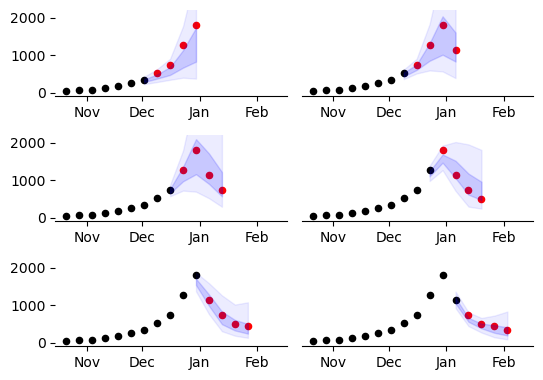

In [42]:
fig,ax=plt.subplots(nrows=int(len(files)/2), ncols=2, figsize=(8.3/3*2, 11.7/3))

ax = ax.flatten()

for i, (data_train, data_forecast, simout) in enumerate(zip(data_trains, data_forecasts, simouts)):
      
   # visualise data
   ax[i].scatter(data_train.index, data_train, marker='o', s=20, color='black')
   ax[i].scatter(data_forecast.index, data_forecast, marker='o', s=20, color='red')
   # visualise model
   x = simout['target_end_date'].unique()
   ax[i].fill_between(x, np.squeeze(simout[simout['output_type_id'] == 0.025][['value']].values),
                     np.squeeze(simout[simout['output_type_id'] == 1-0.025][['value']].values),
                        color='blue', alpha=0.075)
   ax[i].fill_between(x, np.squeeze(simout[simout['output_type_id'] == 0.25][['value']].values),
                     np.squeeze(simout[simout['output_type_id'] == 0.75][['value']].values),
                        color='blue', alpha=0.15)
   
   # no spines
   ax[i].spines['top'].set_visible(False)
   ax[i].spines['right'].set_visible(False)
   ax[i].spines['left'].set_visible(False)
   # yticks
   ax[i].set_yticks([0, 1000, 2000])
   ax[i].set_yticklabels([0, 1000, 2000])
   if i % 2 != 0:
      ax[i].set_yticks([])
   # months only
   ax[i].xaxis.set_major_locator(mdates.MonthLocator())
   ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
   # axlims
   ax[i].set_xlim([start_visualisation, stop_data_train+timedelta(weeks=6)])
   ax[i].set_ylim([-100,2200])

plt.tight_layout()
plt.savefig(f'{season}-{model}-FIT.pdf')
plt.show()
plt.close()